In [ ]:
!pip install pytorch-lightning==1.5.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.1.3
    Uninstalling pytorch-lightning-2.1.3:
      Successfully uninstalled pytorch-lightning-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
arviz 0.

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)
import pytorch_lightning as pl

In [ ]:
# Define MNISTDataModule class to prepare and provide data for training
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    # Prepare data by downloading MNIST dataset
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
# Detective -> output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(in_features=320, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 1st conv layer
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x) # output layer
        return torch.sigmoid(x)


In [ ]:
# Generate Fake Data: ouput like real data
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(in_features=latent_dim, out_features=7*7*64)
        self.ct1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2)
        self.ct2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2)
        self.conv = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=7)

    def forward(self, x):
        # Pass altent space input into linear layer and reshape
        x = self.linear1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)

        # Upsample to 16x16
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34*34
        x = self.ct2(x)
        x = F.relu(x)

        return self.conv(x)

In [ ]:
# TODO: GAN

class GAN(pl.LightningModule):
    def __init__ (self, latent_dim=100, lr = 0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # random noise
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, x):
        return self.generator(x)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch

        # Sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # Train Generator
        if optimizer_idx == 0:
            # Generate images max log(D(G(z)))
            fake_imgs = self(z)
            y_hat = self.discriminator(fake_imgs)

            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)

            g_loss = self.adversarial_loss(y_hat, y)

            log_dict = {'g_loss': g_loss}
            return {'loss': g_loss, 'progress_bar': log_dict, "log": log_dict}

        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        if optimizer_idx == 1:
            # how well can it label as real
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(real_imgs.size(0), 1)
            y_real = y_real.type_as(real_imgs)

            real_loss = self.adversarial_loss(y_hat_real, y_real)

            # how well can it label as fake
            y_hat_fake = self.discriminator(self(z).detach())
            y_fake = torch.zeros(real_imgs.size(0), 1)
            y_fake = y_fake.type_as(real_imgs)

            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

            # Discriminator loss
            d_loss = (real_loss + fake_loss)/2

            log_dict = {'d_loss': d_loss}
            return {'loss': d_loss, 'progress_bar': log_dict, "log": log_dict}


    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_generator = optim.Adam(self.generator.parameters(), lr=lr)
        opt_discriminator = optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_generator, opt_discriminator], []

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.linear1.weight)
        samples_imgs = self(z).cpu()
        print('epoch ', self.current_epoch)
        for i in range (samples_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(samples_imgs.detach()[i,0,:,:], cmap='gray', interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
            plt.show()

    def on_epoch_end(self):
        self.plot_imgs()

In [ ]:
dm = MNISTDataModule()
model = GAN()

epoch  0


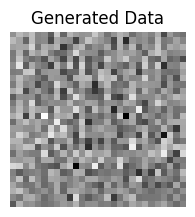

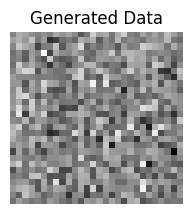

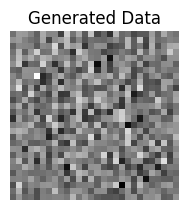

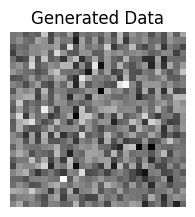

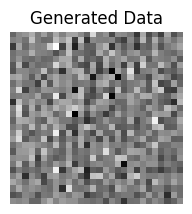

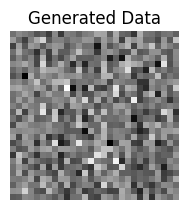

In [ ]:
model.plot_imgs()

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


epoch  0


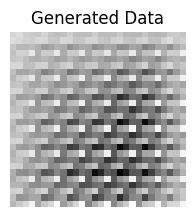

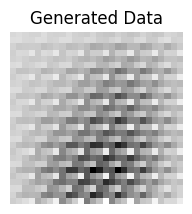

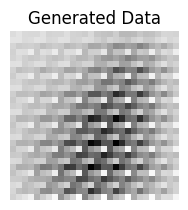

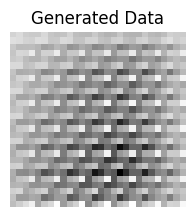

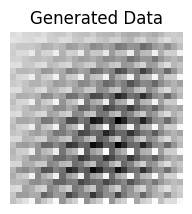

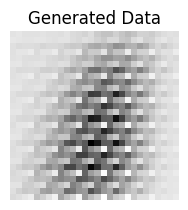

epoch  1


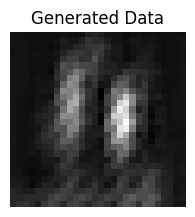

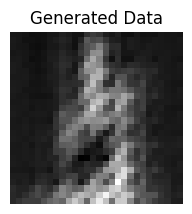

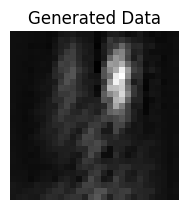

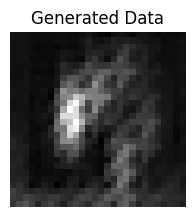

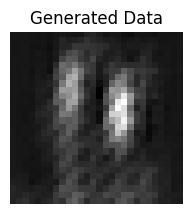

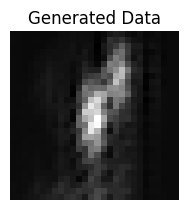

epoch  2


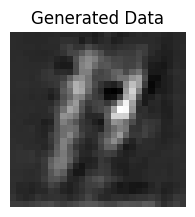

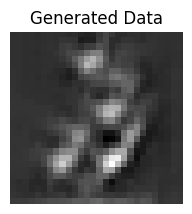

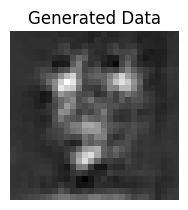

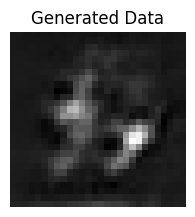

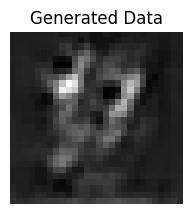

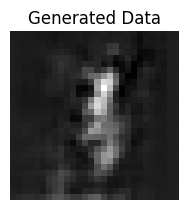

epoch  3


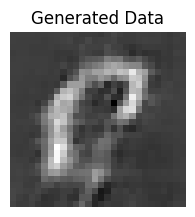

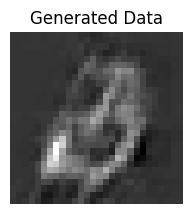

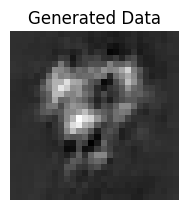

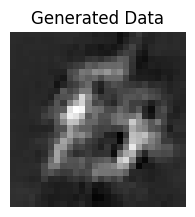

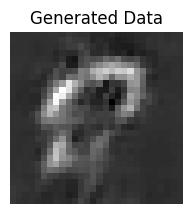

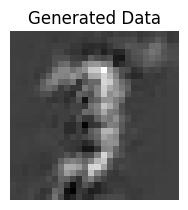

epoch  4


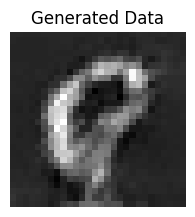

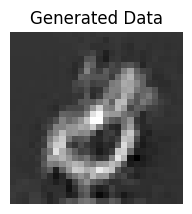

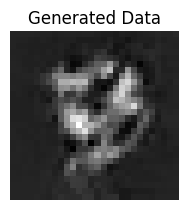

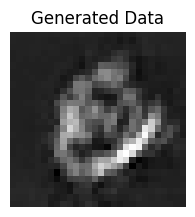

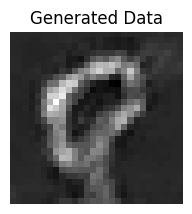

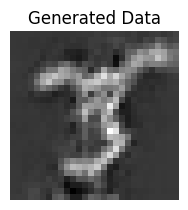

epoch  5


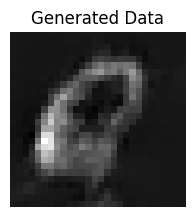

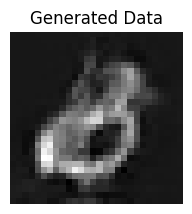

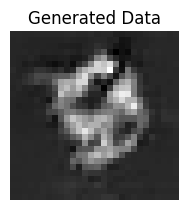

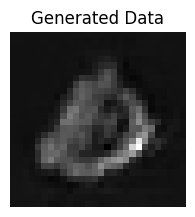

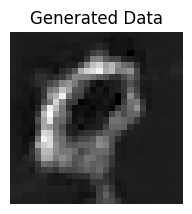

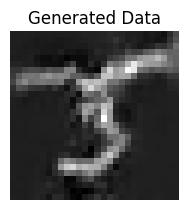

epoch  6


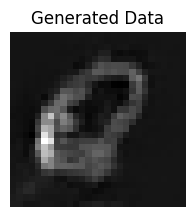

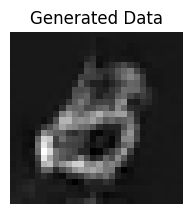

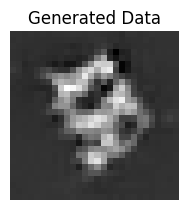

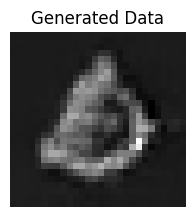

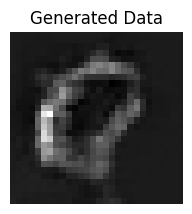

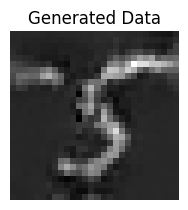

epoch  7


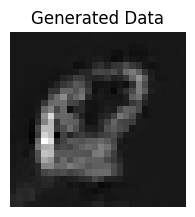

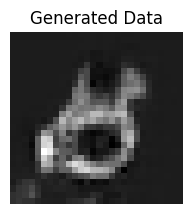

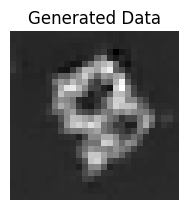

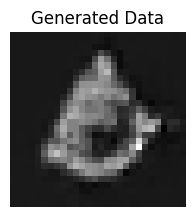

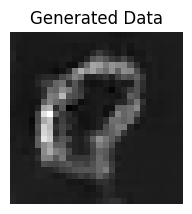

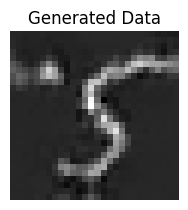

epoch  8


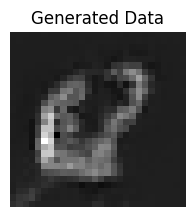

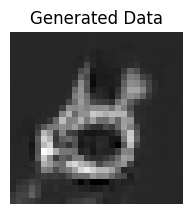

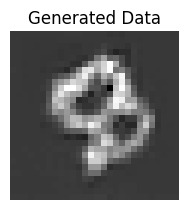

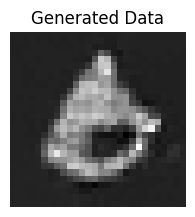

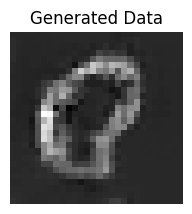

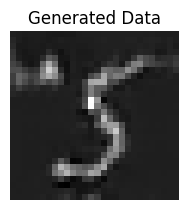

epoch  9


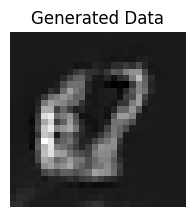

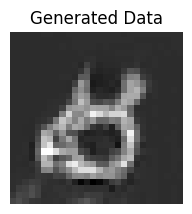

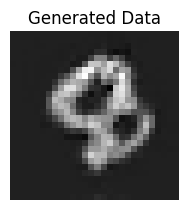

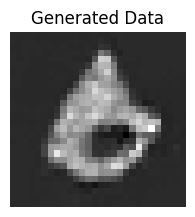

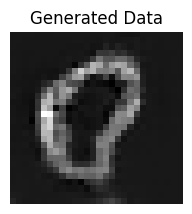

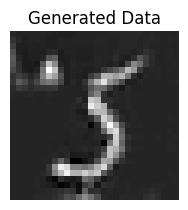

epoch  10


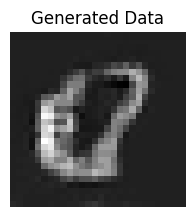

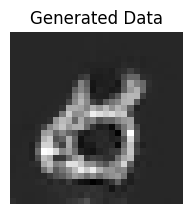

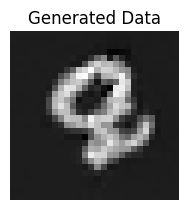

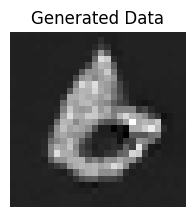

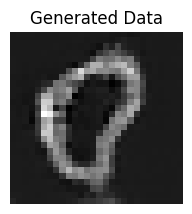

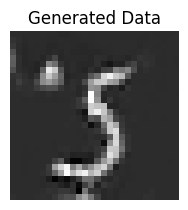

epoch  11


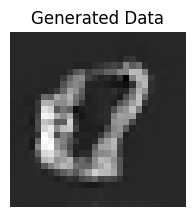

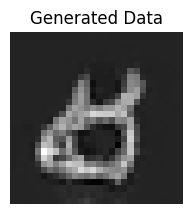

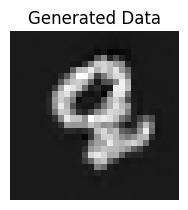

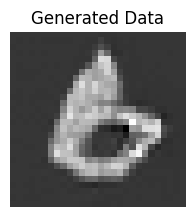

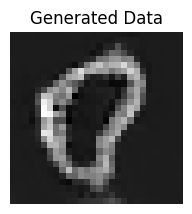

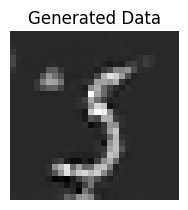

epoch  12


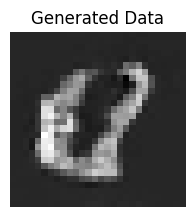

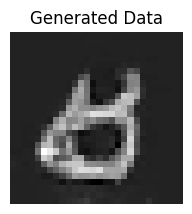

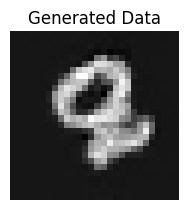

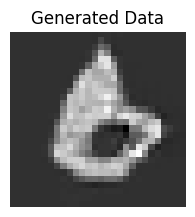

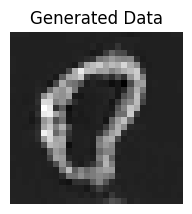

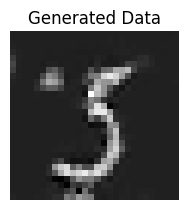

epoch  13


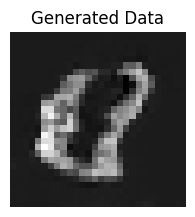

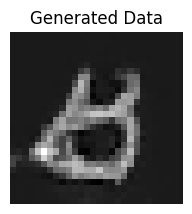

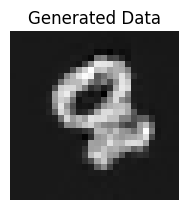

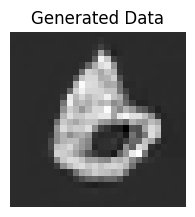

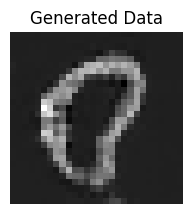

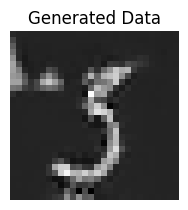

epoch  14


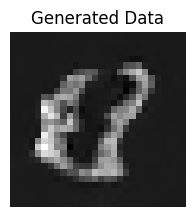

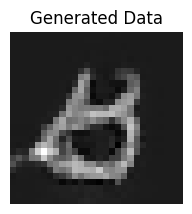

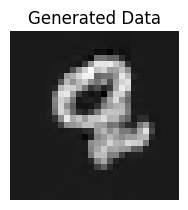

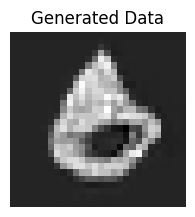

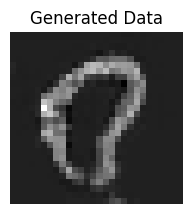

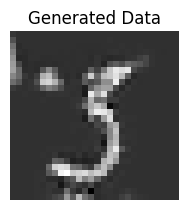

epoch  15


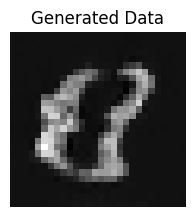

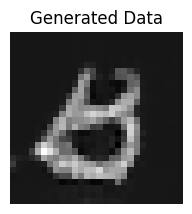

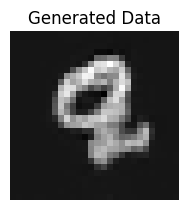

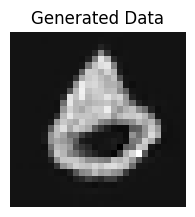

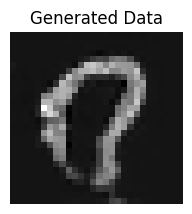

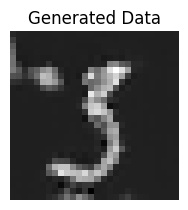

epoch  16


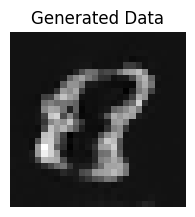

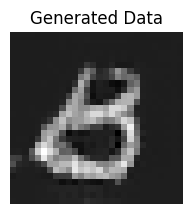

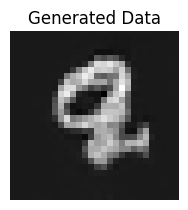

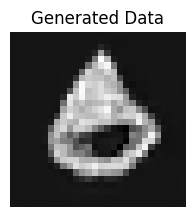

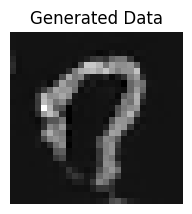

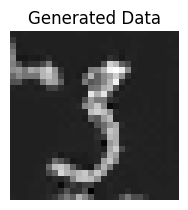

epoch  17


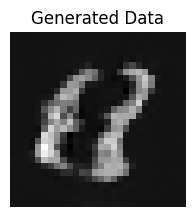

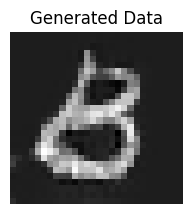

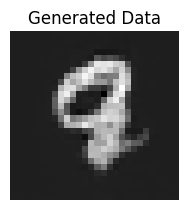

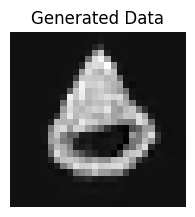

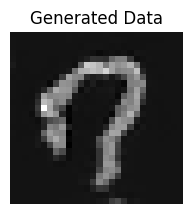

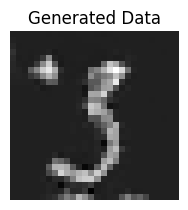

epoch  18


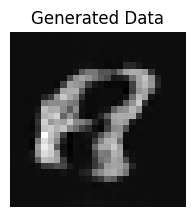

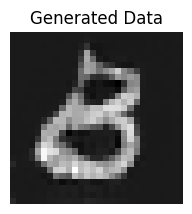

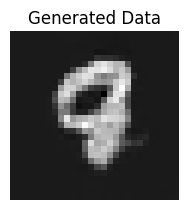

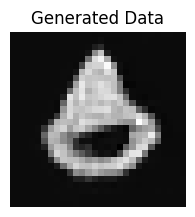

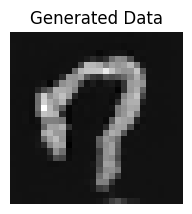

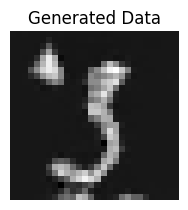

epoch  19


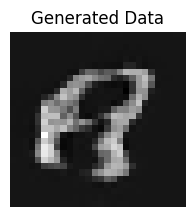

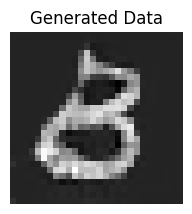

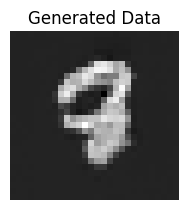

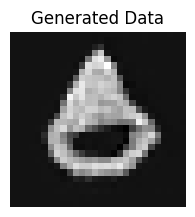

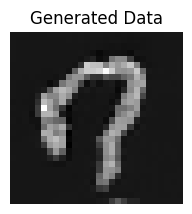

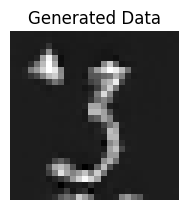

In [9]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)